# Deep Learning Reminders

## Training a perceptron



In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Perceptron

In [2]:
# Load the California housing dataset
X, y = load_iris(return_X_y=True)

In [3]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [4]:
# Rescale the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [5]:
# Fit the linear regression model
perc = Perceptron()
perc.fit(X_train, y_train)

Perceptron()

In [6]:
# Print the R2-score on train and test
print('R2-score on train set:', perc.score(X_train, y_train))
print('R2-score on test set:', perc.score(X_test, y_test))

R2-score on train set: 0.9285714285714286
R2-score on test set: 0.8421052631578947


In [7]:
print('weights:', perc.coef_)
print('bias:', perc.intercept_)

weights: [[-0.49201984  2.77164495 -3.07208498 -2.51124259]
 [ 0.41482008 -1.94508614  3.2852582  -2.60994774]
 [-0.32320969  0.48524348  5.73376173  4.93525738]]
bias: [-2. -3. -6.]


### There's more

In [1]:
import numpy as np

class LogicalGatePerceptron:
    def __init__(self, weights: np.array, bias: float):
        self.weights = weights
        self.bias = bias
    
    def forward(self, X: np.array) -> int:
        return (np.dot(X, self.weights) + self.bias > 0).astype(int)

In [2]:
# Define X and y
X = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
y = [0, 0, 0, 1]

In [3]:
gate = LogicalGatePerceptron(np.array([1, 1]), -1)
y_pred = gate.forward(X)
print('Error:', (y - y_pred).sum())

Error: 0


## Training a neural network for regression

In [1]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
X, y = fetch_california_housing(return_X_y=True)
X.shape

(20640, 8)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.2, random_state=0)

In [5]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
class CaliforniaDataset(Dataset):
    def __init__(self, X: np.array, y: np.array):         
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor]:
        return self.X[idx], self.y[idx]

In [7]:
# Instantiate datasets
training_data = CaliforniaDataset(X_train, y_train)
test_data = CaliforniaDataset(X_test, y_test)
# Instantiate data loaders
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [9]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 24):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.output = nn.Linear(self.hidden_units, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.output(x)
        return output

In [10]:
# Instantiate the network
net = Net(X_train.shape[1])
# Generate one random sample of 8 features
random_data = torch.rand((1, X_train.shape[1]))
# Compute the forward propagation
print(net(random_data))

tensor([[-0.0003]], grad_fn=<AddmmBackward0>)


In [11]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [12]:
losses = []
# Loop over the dataset multiple times
for epoch in range(10):  
    # Reset the loss for this epoch
    running_loss = 0.
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs per batch: data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward propagate + backward + optimize
        outputs = net(inputs)
        # Unsqueeze for dimension matching
        labels = labels.unsqueeze(1)
        # Compute the loss
        loss = criterion(outputs, labels)
        # Backpropagate and update the weights
        loss.backward()
        optimizer.step()
        # Add this loss to the running loss
        running_loss += loss.item()
    # Compute the loss for this epoch and add it to the list
    epoch_loss = running_loss / len(train_dataloader)
    losses.append(epoch_loss)
    # Print the epoch and training loss
    print(f'[epoch {epoch + 1}] loss: {epoch_loss:.3f}')

print('Finished Training')

[epoch 1] loss: 1.760
[epoch 2] loss: 0.560
[epoch 3] loss: 0.438
[epoch 4] loss: 0.402
[epoch 5] loss: 0.385
[epoch 6] loss: 0.373
[epoch 7] loss: 0.360
[epoch 8] loss: 0.350
[epoch 9] loss: 0.345
[epoch 10] loss: 0.337
Finished Training


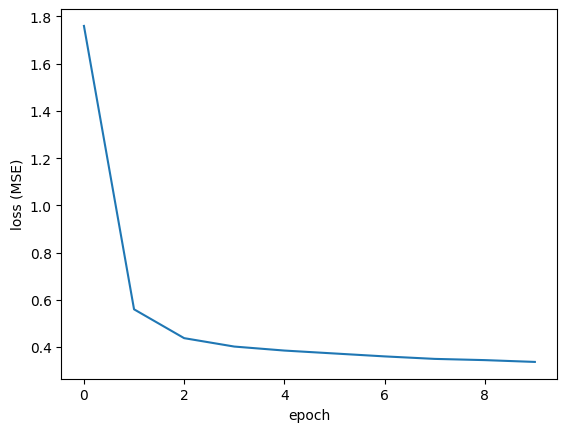

In [13]:
plt.plot(losses)
plt.xlabel('epoch')
plt.ylabel('loss (MSE)')
plt.show()

In [14]:
# Compute the predictions with the trained neural network
y_train_pred = net(torch.tensor((X_train))).detach().numpy()
y_test_pred = net(torch.tensor((X_test))).detach().numpy()
# Compute the R2-score
print('R2-score on training set:', r2_score(y_train, y_train_pred))
print('R2-score on test set:', r2_score(y_test, y_test_pred))

R2-score on training set: 0.7542622050620708
R2-score on test set: 0.7401526252651656


### There's more

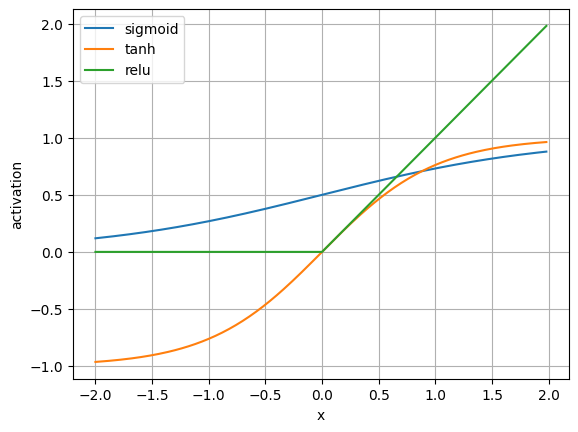

In [2]:
import numpy as np
import matplotlib.pyplot as plt
x = np.arange(-2, 2, 0.02)
sigmoid = 1./(1+np.exp(-x))
tanh = (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))
relu = np.max([np.zeros(len(x)), x], axis=0)
plt.plot(x, sigmoid)
plt.plot(x, tanh)
plt.plot(x, relu)
plt.grid()
plt.xlabel('x')
plt.ylabel('activation')
plt.legend(['sigmoid', 'tanh', 'relu'])
plt.show()

## Training a neural network for binary classification

In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
X, y = load_breast_cancer(return_X_y=True)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X.astype(np.float32), y.astype(np.float32), test_size=0.2, random_state=0)

In [4]:
class BreastCancerDataset(Dataset):
    def __init__(self, X: np.array, y: np.array, x_scaler: StandardScaler = None):
        if x_scaler is None:
            self.x_scaler = StandardScaler()
            X = self.x_scaler.fit_transform(X)
        else:
            self.x_scaler = x_scaler
            X = self.x_scaler.transform(X)           
        self.X = torch.from_numpy(X)
        self.y = torch.from_numpy(y)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor]:
        return self.X[idx], self.y[idx]


In [5]:
training_data = BreastCancerDataset(X_train, y_train)
test_data = BreastCancerDataset(X_test, y_test, training_data.x_scaler)
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [6]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 24):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.output = nn.Linear(self.hidden_units, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = torch.sigmoid(self.output(x))
        return output

In [7]:
# Instantiate the network
net = Net(X_train.shape[1])
# Generate one random sample
random_data = torch.rand((1, X_train.shape[1]))
# Compute the forward propagation
print(net(random_data))

tensor([[0.4487]], grad_fn=<SigmoidBackward0>)


In [8]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [9]:
train_losses = []
test_losses = []
# Loop over the dataset 50 times
for epoch in range(50):
    ## Train the model on the training set
    running_train_loss = 0.
    # Switch to train mode
    net.train()
    # Loop over the batches in train set
    for i, data in enumerate(train_dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        # Zero the parameter gradients
        optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        optimizer.step()
        # Add current loss to running loss
        running_train_loss += loss.item()
    # Once epoch is over, compute and store the epoch loss
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)

    ## Evaluate the model on the test set
    running_test_loss = 0.
    # Switch to eval model
    net.eval()
    with torch.no_grad():
        # Loop over the batches in test set
        for i, data in enumerate(test_dataloader, 0):
            # Get the inputs
            inputs, labels = data
            # Compute forward propagation
            outputs = net(inputs)
            # Compute loss
            loss = criterion(outputs, labels.unsqueeze(1))
            # Add to running loss
            running_test_loss += loss.item()
        # Compute and store the epoch loss
        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)


    # Print stats
    print(f'[epoch {epoch + 1}] Training loss: {train_epoch_loss:.3f} | Test loss: {test_epoch_loss:.3f}')


print('Finished Training')

[epoch 1] Training loss: 0.709 | Test loss: 0.684
[epoch 2] Training loss: 0.669 | Test loss: 0.651
[epoch 3] Training loss: 0.639 | Test loss: 0.610
[epoch 4] Training loss: 0.601 | Test loss: 0.560
[epoch 5] Training loss: 0.541 | Test loss: 0.498
[epoch 6] Training loss: 0.468 | Test loss: 0.431
[epoch 7] Training loss: 0.394 | Test loss: 0.358
[epoch 8] Training loss: 0.339 | Test loss: 0.297
[epoch 9] Training loss: 0.268 | Test loss: 0.243
[epoch 10] Training loss: 0.234 | Test loss: 0.205
[epoch 11] Training loss: 0.182 | Test loss: 0.178
[epoch 12] Training loss: 0.148 | Test loss: 0.153
[epoch 13] Training loss: 0.136 | Test loss: 0.138
[epoch 14] Training loss: 0.110 | Test loss: 0.122
[epoch 15] Training loss: 0.096 | Test loss: 0.126
[epoch 16] Training loss: 0.090 | Test loss: 0.109
[epoch 17] Training loss: 0.082 | Test loss: 0.101
[epoch 18] Training loss: 0.085 | Test loss: 0.094
[epoch 19] Training loss: 0.073 | Test loss: 0.102
[epoch 20] Training loss: 0.068 | Test l

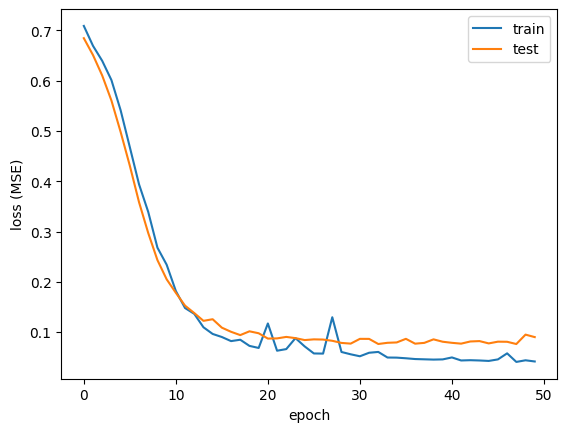

In [10]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (BCE)')
plt.legend()
plt.show()

In [11]:
# Compute the predictions with the trained neural network
y_train_pred = net(torch.tensor((training_data.x_scaler.transform(X_train)))).detach().numpy() > 0.5
y_test_pred = net(torch.tensor((training_data.x_scaler.transform(X_test)))).detach().numpy() > 0.5
# Compute the accuracy score
print('Accuracy on training set:', accuracy_score(y_train, y_train_pred))
print('Accuracy on test set:', accuracy_score(y_test, y_test_pred))

Accuracy on training set: 0.9912087912087912
Accuracy on test set: 0.9649122807017544


## Training a multiclass classification neural network

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307), (0.3081)), transforms.Lambda(torch.flatten)])

In [3]:
trainset = MNIST('./data', train=True, download=True, transform=transform)
train_dataloader = DataLoader(trainset, batch_size=64, shuffle=True)
testset = MNIST('./data', train=False, download=True, transform=transform)
test_dataloader = DataLoader(testset, batch_size=64, shuffle=True)

In [4]:
class Net(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int = 24):
        super(Net, self).__init__()
        self.hidden_units = hidden_units
        self.fc1 = nn.Linear(input_shape, self.hidden_units)
        self.fc2 = nn.Linear(self.hidden_units, self.hidden_units)
        self.output = nn.Linear(self.hidden_units, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = torch.softmax(self.output(x), dim=1)
        return output

In [5]:
# Instantiate the model
net = Net(784)
# Generate randomly one random 28x28 image as a 784 values tensor
random_data = torch.rand((1, 784))
result = net(random_data)
print('Resulting output tensor:', result)
print('Sum of the output tensor:', result.sum())

Resulting output tensor: tensor([[0.0993, 0.0930, 0.1166, 0.0982, 0.0907, 0.1209, 0.0897, 0.0772, 0.0873,
         0.1272]], grad_fn=<SoftmaxBackward0>)
Sum of the output tensor: tensor(1., grad_fn=<SumBackward0>)


In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [7]:
def epoch_step(net, dataloader, training_set: bool):
    running_loss = 0.
    correct = 0.
    for i, data in enumerate(dataloader, 0):
        # Get the inputs: data is a list of [inputs, labels]
        inputs, labels = data
        if training_set:
            # Zero the parameter gradients
            optimizer.zero_grad()
        # Forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        if training_set:
            loss.backward()
            optimizer.step()
        # Add correct predictions for this batch
        correct += (outputs.argmax(dim=1) == labels).float().sum()
        # Compute loss for this batch
        running_loss += loss.item()

    return running_loss, correct

In [8]:
# Create empty lists to store the losses and accuracies
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []

# Loop over the dataset 20 times for 20 epochs
for epoch in range(20):  
    ## Train the model on the training set
    net.train()
    running_train_loss, correct = epoch_step(net, dataloader=train_dataloader, training_set=True)
    # Compute and store loss and accuracy for this epoch
    train_epoch_loss = running_train_loss / len(train_dataloader)
    train_losses.append(train_epoch_loss)
    train_epoch_accuracy = correct / len(trainset)
    train_accuracy.append(train_epoch_accuracy)

    ## Evaluate the model on the test set
    net.eval()
    with torch.no_grad():
        running_test_loss, correct = epoch_step(net, dataloader=test_dataloader, training_set=False)

        test_epoch_loss = running_test_loss / len(test_dataloader)
        test_losses.append(test_epoch_loss)
        test_epoch_accuracy = correct / len(testset)
        test_accuracy.append(test_epoch_accuracy)

    # Print stats
    print(f'[epoch {epoch + 1}] Training: loss={train_epoch_loss:.3f} accuracy={train_epoch_accuracy:.3f} |\
\t Test: loss={test_epoch_loss:.3f} accuracy={test_epoch_accuracy:.3f}')

print('Finished Training')

[epoch 1] Training: loss=1.628 accuracy=0.858 |	 Test: loss=1.552 accuracy=0.915
[epoch 2] Training: loss=1.548 accuracy=0.918 |	 Test: loss=1.541 accuracy=0.923
[epoch 3] Training: loss=1.536 accuracy=0.928 |	 Test: loss=1.532 accuracy=0.932
[epoch 4] Training: loss=1.529 accuracy=0.935 |	 Test: loss=1.527 accuracy=0.936
[epoch 5] Training: loss=1.524 accuracy=0.940 |	 Test: loss=1.520 accuracy=0.943
[epoch 6] Training: loss=1.518 accuracy=0.945 |	 Test: loss=1.525 accuracy=0.937
[epoch 7] Training: loss=1.515 accuracy=0.948 |	 Test: loss=1.519 accuracy=0.942
[epoch 8] Training: loss=1.511 accuracy=0.951 |	 Test: loss=1.513 accuracy=0.950
[epoch 9] Training: loss=1.509 accuracy=0.953 |	 Test: loss=1.514 accuracy=0.947
[epoch 10] Training: loss=1.507 accuracy=0.955 |	 Test: loss=1.512 accuracy=0.950
[epoch 11] Training: loss=1.506 accuracy=0.957 |	 Test: loss=1.509 accuracy=0.952
[epoch 12] Training: loss=1.503 accuracy=0.959 |	 Test: loss=1.508 accuracy=0.953
[epoch 13] Training: loss

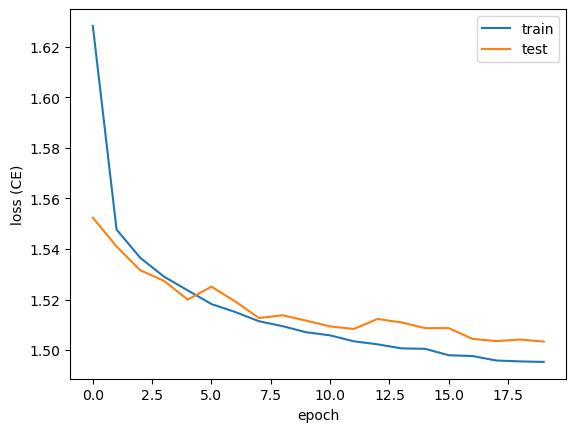

In [9]:
plt.plot(train_losses, label='train')
plt.plot(test_losses, label='test')
plt.xlabel('epoch')
plt.ylabel('loss (CE)')
plt.legend()
plt.show()

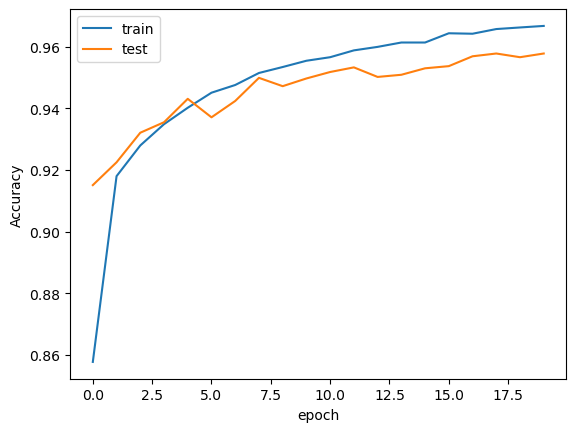

In [10]:
plt.plot(train_accuracy, label='train')
plt.plot(test_accuracy, label='test')
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [10]:
# Save the model's state dict
torch.save(net.state_dict(), 'path_to_model.pt')
# Instantiate a new model
new_model = Net(784)
# Load the model's weights
new_model.load_state_dict(torch.load('path_to_model.pt'))

<All keys matched successfully>

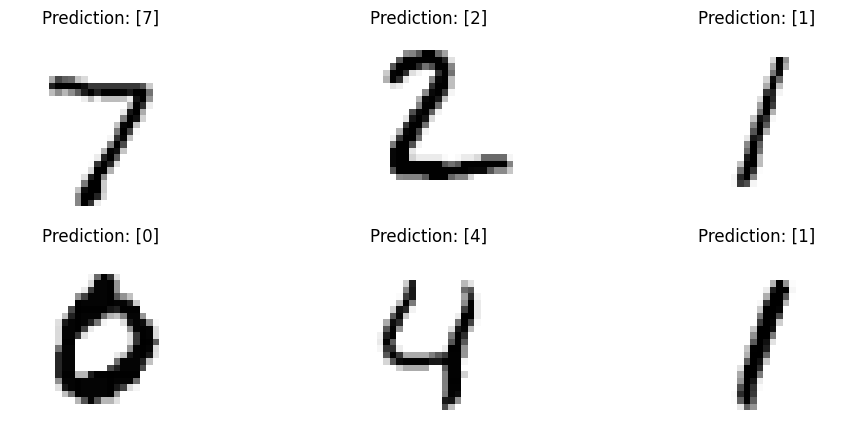

In [39]:
plt.figure(figsize=(12, 8))
for i in range(6):
    plt.subplot(3, 3, i+1)
    # Compute the predicted number
    pred = new_model(testset[i][0].unsqueeze(0)).argmax(axis=1)
    # Display the image and predicted number as title
    plt.imshow(testset[i][0].detach().numpy().reshape(28, 28), cmap='gray_r')
    plt.title(f'Prediction: {pred.detach().numpy()}')
    plt.axis('off')